In [1]:
import pandas as pd
import numpy  as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from tensorflow import keras
from keras.layers import Dense, LSTM

In [21]:
scaler = RobustScaler()

train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

pd_data = test_data

print(train_data.head())

   id  breath_id   R   C  time_step       u_in  u_out   pressure
0   1          1  20  50   0.000000   0.083334      0   5.837492
1   2          1  20  50   0.033652  18.383041      0   5.907794
2   3          1  20  50   0.067514  22.509278      0   7.876254
3   4          1  20  50   0.101542  22.808822      0  11.742872
4   5          1  20  50   0.135756  25.355850      0  12.234987


In [3]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    
    return df

In [4]:
print("\ntrain data...\n")
train_data = add_features(train_data)

print("\test data...\n")
test_data = add_features(test_data)


train data...

	est data...



In [5]:
pressure_targets = train_data[['pressure']].to_numpy().reshape(-1, 80)

# train_data = train_data.drop(['pressure', 'id', 'breath_id'], axis=1)
# test_data = test_data.drop(['id', 'breath_id'], axis=1)

train_data = train_data.drop(['pressure', 'id', 'breath_id'], axis=1)
test_data = test_data.drop(['id', 'breath_id'], axis=1)

print(train_data.shape, test_data.shape, pressure_targets.shape)

(6036000, 38) (4024000, 38) (75450, 80)


In [20]:
test_data.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [7]:
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

print(train_data[:5])

[[ 0.00000000e+00  7.50000000e-01 -9.89052161e-01 -9.37384450e-01
  -1.00000000e+00  0.00000000e+00 -6.65541311e-01 -5.16580501e-01
  -4.96657632e-01 -7.25227791e-01 -8.64120606e-01 -1.00000000e+00
   2.89020724e+00 -1.00000000e+00 -8.42526591e-01 -1.00000000e+00
   3.66402550e+00 -1.00000000e+00 -8.19257888e-01 -1.00000000e+00
   3.74391547e+00 -1.00000000e+00 -7.94151600e-01 -1.00000000e+00
   4.27782420e+00 -1.00000000e+00  1.12207936e-01  9.08068790e-01
   3.26940916e-01  1.27386353e+00  4.71408803e-01  0.00000000e+00
   2.17993186e-01  0.00000000e+00  1.21027987e-01  0.00000000e+00
   6.83146754e-02  0.00000000e+00]
 [ 0.00000000e+00  7.50000000e-01 -9.63608151e-01  3.04927811e+00
  -1.00000000e+00  0.00000000e+00 -6.65541311e-01 -5.14030884e-01
  -4.96023692e-01 -6.76829391e-01 -8.47360186e-01 -1.00000000e+00
   3.73971160e+00 -1.00000000e+00 -8.42526591e-01 -1.00000000e+00
   3.72421814e+00 -1.00000000e+00 -8.19257888e-01 -1.00000000e+00
   4.25618879e+00 -1.00000000e+00 -7.9415

In [8]:
features = train_data.shape[-1]

train_data = train_data.reshape(-1, 80, features)
test_data = test_data.reshape(-1, 80, features)

print(train_data.shape, test_data.shape)

(75450, 80, 38) (50300, 80, 38)


In [9]:
def plot_history(history):
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


fold 0

Epoch 1/20
57/57 [==============================] - 18s 135ms/step - loss: 32.3932 - mse: 32.3932 - val_loss: 9.0517 - val_mse: 9.0517
Epoch 2/20
57/57 [==============================] - 7s 121ms/step - loss: 6.8269 - mse: 6.8269 - val_loss: 4.7481 - val_mse: 4.7481
Epoch 3/20
57/57 [==============================] - 7s 119ms/step - loss: 4.4079 - mse: 4.4079 - val_loss: 3.1492 - val_mse: 3.1492
Epoch 4/20
57/57 [==============================] - 7s 121ms/step - loss: 3.2200 - mse: 3.2200 - val_loss: 2.6621 - val_mse: 2.6621
Epoch 5/20
57/57 [==============================] - 7s 123ms/step - loss: 2.6328 - mse: 2.6328 - val_loss: 2.3620 - val_mse: 2.3620
Epoch 6/20
57/57 [==============================] - 7s 123ms/step - loss: 2.3135 - mse: 2.3135 - val_loss: 2.2205 - val_mse: 2.2205
Epoch 7/20
57/57 [==============================] - 7s 123ms/step - loss: 1.9925 - mse: 1.9925 - val_loss: 1.6381 - val_mse: 1.6381
Epoch 8/20
57/57 [==============================] - 7s 124ms/ste

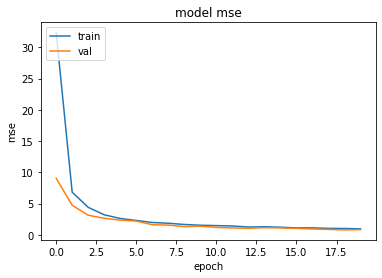


fold 1

Epoch 1/20
57/57 [==============================] - 12s 148ms/step - loss: 33.5094 - mse: 33.5094 - val_loss: 9.7630 - val_mse: 9.7630
Epoch 2/20
57/57 [==============================] - 7s 121ms/step - loss: 6.7423 - mse: 6.7423 - val_loss: 4.5973 - val_mse: 4.5973
Epoch 3/20
57/57 [==============================] - 7s 123ms/step - loss: 4.2000 - mse: 4.2000 - val_loss: 3.2278 - val_mse: 3.2278
Epoch 4/20
57/57 [==============================] - 7s 122ms/step - loss: 3.1389 - mse: 3.1389 - val_loss: 2.3981 - val_mse: 2.3981
Epoch 5/20
57/57 [==============================] - 7s 124ms/step - loss: 2.5387 - mse: 2.5387 - val_loss: 1.9470 - val_mse: 1.9470
Epoch 6/20
57/57 [==============================] - 7s 121ms/step - loss: 2.2100 - mse: 2.2100 - val_loss: 1.7422 - val_mse: 1.7422
Epoch 7/20
57/57 [==============================] - 7s 122ms/step - loss: 1.9201 - mse: 1.9201 - val_loss: 1.5121 - val_mse: 1.5121
Epoch 8/20
57/57 [==============================] - 7s 121ms/ste

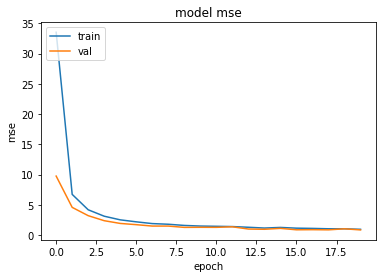


fold 2

Epoch 1/20
57/57 [==============================] - 11s 139ms/step - loss: 33.0637 - mse: 33.0637 - val_loss: 9.3551 - val_mse: 9.3551
Epoch 2/20
57/57 [==============================] - 7s 123ms/step - loss: 6.8960 - mse: 6.8960 - val_loss: 4.3303 - val_mse: 4.3303
Epoch 3/20
57/57 [==============================] - 7s 121ms/step - loss: 4.4573 - mse: 4.4573 - val_loss: 3.0821 - val_mse: 3.0821
Epoch 4/20
57/57 [==============================] - 7s 120ms/step - loss: 3.1384 - mse: 3.1384 - val_loss: 2.3199 - val_mse: 2.3199
Epoch 5/20
57/57 [==============================] - 7s 124ms/step - loss: 2.6473 - mse: 2.6473 - val_loss: 1.9012 - val_mse: 1.9012
Epoch 6/20
57/57 [==============================] - 7s 123ms/step - loss: 2.3386 - mse: 2.3386 - val_loss: 2.1803 - val_mse: 2.1803
Epoch 7/20
57/57 [==============================] - 7s 122ms/step - loss: 2.0887 - mse: 2.0887 - val_loss: 1.7350 - val_mse: 1.7350
Epoch 8/20
57/57 [==============================] - 7s 123ms/ste

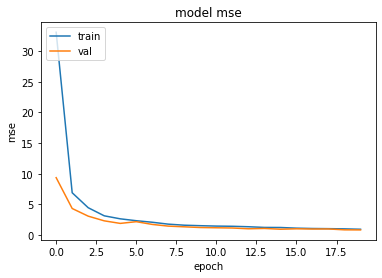


fold 3

Epoch 1/20
57/57 [==============================] - 11s 135ms/step - loss: 32.2195 - mse: 32.2195 - val_loss: 9.7813 - val_mse: 9.7813
Epoch 2/20
57/57 [==============================] - 7s 120ms/step - loss: 6.7363 - mse: 6.7363 - val_loss: 4.8974 - val_mse: 4.8974
Epoch 3/20
57/57 [==============================] - 7s 120ms/step - loss: 4.1931 - mse: 4.1931 - val_loss: 3.2658 - val_mse: 3.2658
Epoch 4/20
57/57 [==============================] - 7s 121ms/step - loss: 3.3660 - mse: 3.3660 - val_loss: 2.5223 - val_mse: 2.5223
Epoch 5/20
57/57 [==============================] - 7s 122ms/step - loss: 2.6268 - mse: 2.6268 - val_loss: 2.1111 - val_mse: 2.1111
Epoch 6/20
57/57 [==============================] - 7s 123ms/step - loss: 2.2351 - mse: 2.2351 - val_loss: 1.8181 - val_mse: 1.8181
Epoch 7/20
57/57 [==============================] - 7s 122ms/step - loss: 2.0063 - mse: 2.0063 - val_loss: 1.6321 - val_mse: 1.6321
Epoch 8/20
57/57 [==============================] - 7s 124ms/ste

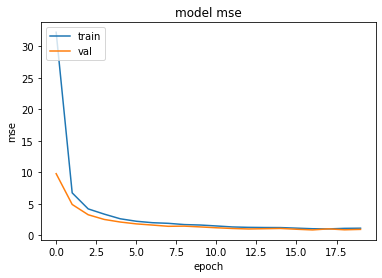

In [10]:
kfold_splits = 4
kfold = KFold(n_splits=kfold_splits, shuffle=False)

test_predictions = []

for fold, (train_index, test_index) in enumerate(kfold.split(train_data, pressure_targets)):
    print(f"\nfold {fold}\n")

    x_train, x_valid = train_data[train_index], train_data[test_index]
    y_train, y_valid = pressure_targets[train_index], pressure_targets[test_index]
    
    model = keras.models.Sequential()
    
    model.add(LSTM(250, return_sequences=True, input_shape=(80, features)))
    model.add(LSTM(250, return_sequences=True, dropout=0.2))
    model.add(LSTM(250, return_sequences=True, dropout=0.3))
    model.add(Dense(250))
    model.add(Dense(1))
        
    model.compile(
        loss='mse', 
        optimizer='adam', 
        metrics=['mse'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=(x_valid, y_valid), 
                        epochs=20, 
                        batch_size=1000)
    
    model.save(f'models/fold-{fold}.h5')
    plot_history(history)
    
    
    test_predictions.append(model.predict(test_data))

In [11]:
mse = []

for i in range(38):
    x_valid_2d = x_valid.reshape(18862*80, 38)

    np.random.shuffle(x_valid_2d[:, i])

    x_valid_2d = x_valid_2d.reshape(18862, 80, 38)
    
    pressure_predictions = model.predict(x_valid_2d)

    plot_pressure_targets = pressure_predictions.reshape(1, 1508960)
    plot_y_valid = y_valid.reshape(1, 1508960)
    
    mse_val = (np.square(plot_y_valid - plot_pressure_targets)).mean(axis=1)
    
    print(f"--------- {i} ---------") 
    print(mse_val)
    print(f"---------------------") 
    
    mse.append(mse_val)

--------- 0 ---------
[8.03783984]
---------------------
--------- 1 ---------
[8.72592264]
---------------------
--------- 2 ---------
[0.98851551]
---------------------
--------- 3 ---------
[8.14651074]
---------------------
--------- 4 ---------
[1.22743119]
---------------------
--------- 5 ---------
[3.06150561]
---------------------
--------- 6 ---------
[1.18719632]
---------------------
--------- 7 ---------
[1.0190667]
---------------------
--------- 8 ---------
[0.95954655]
---------------------
--------- 9 ---------
[2.21764473]
---------------------
--------- 10 ---------
[2.92878778]
---------------------
--------- 11 ---------
[1.27091555]
---------------------
--------- 12 ---------
[2.98615083]
---------------------
--------- 13 ---------
[1.256066]
---------------------
--------- 14 ---------
[2.37115028]
---------------------
--------- 15 ---------
[1.00289723]
---------------------
--------- 16 ---------
[2.78286135]
---------------------
--------- 17 ---------
[0.9

C:\Users\manoj\AppData\Local\Temp\ipykernel_5508\3866969942.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_tick_labels = pd_data.columns[mse_sort_index]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

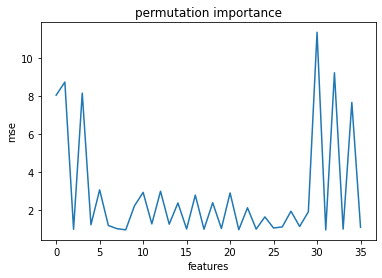

In [23]:
#mse = np.as_array(mse)
mse_sort_index = np.argsort(mse)
x_tick_labels = pd_data.columns[mse_sort_index]

plt.plot(mse)

plt.title('permutation importance')
plt.ylabel('mse')
plt.xlabel('features')

plt.xlabel(x_tick_labels, rotation=90)

plt.show()


In [14]:
pressure_predictions = model.predict(x_valid_2d)

plot_pressure_targets = pressure_predictions.reshape(1, 1508960)
plot_y_valid = y_valid.reshape(1, 1508960)

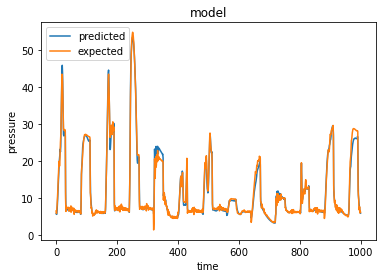

In [15]:
plt.plot(plot_pressure_targets[0, :1000])
plt.plot(plot_y_valid[0, :1000])

plt.title('model')
plt.ylabel('pressure')
plt.xlabel('time')
plt.legend(['predicted', 'expected'], loc='upper left')
plt.show()

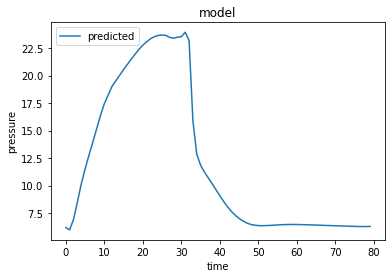

In [16]:
pressure_predictions = sum(test_predictions) / kfold_splits

pressure_predictions = pressure_predictions.reshape(4024000)

plt.plot(pressure_predictions[:80])

plt.title('model')
plt.ylabel('pressure')
plt.xlabel('time')
plt.legend(['predicted'], loc='upper left')
plt.show()

In [ ]:
submission = pd.read_csv("data/sample_submission.csv", index_col=1)
submission["pressure"] = pressure_predictions

submission.to_csv("submission-mse10.csv", index=False)

submission.head()